In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from numpy.linalg import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


%matplotlib inline 

In [2]:
# параметры распределений
mu0 = np.array([-2.,1.])
mu1 = np.array([3.,-0.5])

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mu0.data), torch.eye(2))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mu1.data), torch.eye(2))

In [5]:
d0.sample((10,))

tensor([[-3.4947,  2.4355],
        [-0.7773,  2.1576],
        [-1.7807,  1.7188],
        [-1.8458,  1.5331],
        [-2.2363,  0.7015],
        [-1.6565,  1.0941],
        [-0.7751,  0.7468],
        [-1.3851,  2.6464],
        [-3.1771,  2.4358],
        [-4.2922,  2.9687]])

In [6]:
d1.sample((10,))

tensor([[ 2.0937,  0.1611],
        [ 3.3973,  0.9651],
        [ 1.9155, -0.2243],
        [ 2.2545, -2.7943],
        [ 3.5233,  1.6391],
        [ 4.3992, -1.5743],
        [ 3.5580, -1.4142],
        [ 2.5661,  0.4937],
        [ 1.9317, -2.2780],
        [ 2.1978, -0.0363]])

In [7]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([ 0.6848, -0.6703]), tensor(0.3787)]


In [8]:
log_freq = 50
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.162734
Ошибка после 1 итераций: 0.159723
Ошибка после 2 итераций: 0.157615
Ошибка после 3 итераций: 0.153394
Ошибка после 4 итераций: 0.151518
Ошибка после 5 итераций: 0.148363
Ошибка после 6 итераций: 0.145795
Ошибка после 7 итераций: 0.142713
Ошибка после 8 итераций: 0.140363
Ошибка после 9 итераций: 0.137883
Ошибка после 10 итераций: 0.136214
Ошибка после 11 итераций: 0.134324
Ошибка после 12 итераций: 0.132557
Ошибка после 13 итераций: 0.130141
Ошибка после 14 итераций: 0.128486
Ошибка после 15 итераций: 0.126336
Ошибка после 16 итераций: 0.125248
Ошибка после 17 итераций: 0.123765
Ошибка после 18 итераций: 0.121696
Ошибка после 19 итераций: 0.119805
Ошибка после 20 итераций: 0.118839
Ошибка после 21 итераций: 0.117570
Ошибка после 22 итераций: 0.115865
Ошибка после 23 итераций: 0.114337
Ошибка после 24 итераций: 0.112386
Ошибка после 25 итераций: 0.112160
Ошибка после 26 итераций: 0.110356
Ошибка после 27 итераций: 0.109442
Ошибка после 28 итераций: 0.10

In [9]:
# Берем другое"тестовое" распределение
d0 = torch.distributions.MultivariateNormal(torch.tensor([-0.5, 3]), torch.eye(2))
d1 = torch.distributions.MultivariateNormal(torch.tensor([1.5, -2]), torch.eye(2))
x, y = sample(d0, d1, 1024)

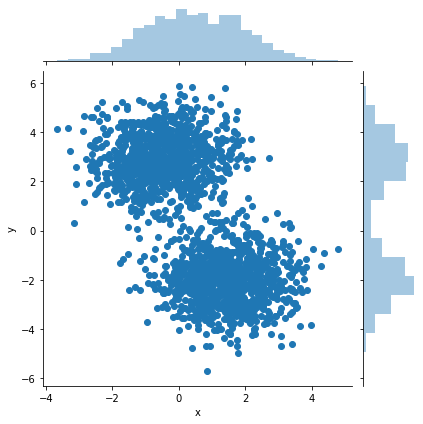

In [10]:
df = pd.DataFrame(x.numpy(), columns=["x", "y"])
sns.jointplot(x="x", y="y", data=df);

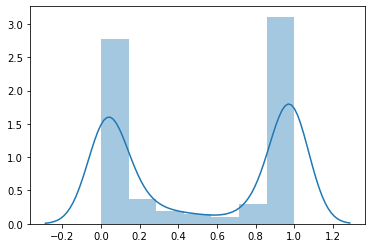

In [11]:
with torch.no_grad():
    dist = torch.sigmoid(layer(x)).numpy()
sns.distplot(dist.flatten());